In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 43kB/s 
     |████████████████████████████████| 512kB 37.7MB/s 
     |████████████████████████████████| 3.8MB 38.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d2147da670995355368d8901886b6024666de3c3018551fff65bad2d7b70db0f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: 

In [ ]:
%cd /content/drive/My Drive/object_detection/data

/content/drive/My Drive/object_detection/data


In [ ]:
!ls

annotations  images


In [ ]:
#creating two dir for training and testing
!mkdir test_labels train_labels

In [ ]:
!ls

annotations	 test_labels	     train_labels
images		 test_labels.csv     train_labels.csv
label_map.pbtxt  test_labels.record  train_labels.record


In [ ]:
#creating two dir for training and testing
!mkdir test_labels train_labels

# lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# Moves the first 400/2000 labels (20% of the labels) to the testing dir: `test_labels`
!ls /content/drive/*/object_detection/data/annotations/xmls/* | sort -R | head -64 | xargs -I{} mv {} test_labels/


# Moves the rest of labels '1600' labels to the training dir: `train_labels`
!ls /content/drive/*/object_detection/data/annotations/xmls/* | xargs -I{} mv {} train_labels/

In [ ]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -qq Cython contextlib2 pillow lxml matplotlib pycocotools

Selecting previously unselected package python-bs4.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

In [ ]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv

import re
import os
import io
import glob
import shutil
import urllib.request
import tarfile
import xml.etree.ElementTree as ET

import tensorflow.compat.v1 as tf
import cv2 

from PIL import Image
from collections import namedtuple, OrderedDict

from google.colab import files

In [ ]:
print(tf.__version__)

1.15.0


In [ ]:
%cd /content/drive/My Drive/object_detection/data

/content/drive/My Drive/object_detection/data


In [ ]:
#adjusted from: https://github.com/datitran/raccoon_dataset
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)

Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.


In [ ]:
# navigate to object detection for model downloading destination
%cd /content/drive/My Drive/object_detection/

/content/drive/My Drive/object_detection


In [ ]:
# downloads the models
!git clone --q https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
%cd /content/drive/My Drive/object_detection/models/research/

/content/drive/My Drive/object_detection/models/research


In [ ]:
# compils the proto buffers
!protoc object_detection/protos/*.proto --python_out=.
# exports PYTHONPATH environment var with research and slim paths
os.environ['PYTHONPATH'] += ':./:./slim/'

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [ ]:
# testing the model builder
!python3 object_detection/builders/model_builder_test.py

In [ ]:
%cd /content/drive/My Drive/object_detection/models/research

/content/drive/My Drive/object_detection/models/research


In [ ]:
#adjusted from: https://github.com/datitran/raccoon_dataset
from object_detection.utils import dataset_util


#change this to the base directory where your data/ is 
data_base_url = '/content/drive/My Drive/object_detection/data/'

#location of images
image_dir = data_base_url +'images/'

def class_text_to_int(row_label):
  if row_label == 'paper':
    return 1
  if row_label == 'cardboard':
    return 2
  if row_label == 'plastic':
    return 3
  if row_label == 'metal':
    return 4
  if row_label == 'glass':
    return 5
  else:
    None

def split(df, group):
  data = namedtuple('data', ['filename', 'object'])
  gb = df.groupby(group)
  return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
	with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
	  encoded_jpg = fid.read()
	encoded_jpg_io = io.BytesIO(encoded_jpg)
	image = Image.open(encoded_jpg_io)
	width, height = image.size
	filename = group.filename.encode('utf8')
	image_format = b'JPG'
	xmins = []
	xmaxs = []
	ymins = []
	ymaxs = []
	classes_text = []
	classes = []

	for index, row in group.object.iterrows():
		xmins.append(row['xmin'] / width)
		xmaxs.append(row['xmax'] / width)
		ymins.append(row['ymin'] / height)
		ymaxs.append(row['ymax'] / height)
		classes_text.append(row['class'].encode('utf8'))
		classes.append(class_text_to_int(row['class']))

	tf_example = tf.train.Example(features=tf.train.Features(feature={
		'image/height': dataset_util.int64_feature(height),
		'image/width': dataset_util.int64_feature(width),
		'image/filename': dataset_util.bytes_feature(filename),
		'image/source_id': dataset_util.bytes_feature(filename),
		'image/encoded': dataset_util.bytes_feature(encoded_jpg),
		'image/format': dataset_util.bytes_feature(image_format),
		'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
		'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
		'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
		'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
		'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
		'image/object/class/label': dataset_util.int64_list_feature(classes),
		}))
	return tf_example
#creates tfrecord for both csv's
for csv in ['train_labels', 'test_labels']:
  writer = tf.io.TFRecordWriter(data_base_url + csv + '.record')
  path = os.path.join(image_dir)
  examples = pd.read_csv(data_base_url + csv + '.csv')
  grouped = split(examples, 'filename')
  for group in grouped:
    tf_example = create_tf_example(group, path)
    writer.write(tf_example.SerializeToString())
    
  writer.close()
  output_path = os.path.join(os.getcwd(), data_base_url + csv + '.record')
  print('Successfully created the TFRecords: {}'.format(data_base_url +csv + '.record'))

Successfully created the TFRecords: /content/drive/My Drive/object_detection/data/train_labels.record
Successfully created the TFRecords: /content/drive/My Drive/object_detection/data/test_labels.record


In [ ]:
# Some models to train on
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
    },
}

# Select a model from `MODELS_CONFIG`.
# I chose ssd_mobilenet_v2 for this project, you could choose any
selected_model = 'ssd_mobilenet_v2'

In [ ]:
%cd /content/drive/My Drive/object_detection/models/research

/content/drive/My Drive/object_detection/models/research


In [ ]:
#the distination folder where the model will be saved
#change this if you have a different working dir
DEST_DIR = '/content/drive/My Drive/object_detection/models/research/pretrained_model'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

#selecting the model
MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#checks if the model has already been downloaded, download it otherwise
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the model and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

In [ ]:
#path to the config file
%%writefile object_detection/samples/configs/ssd_mobilenet_v2_coco.config
# paste the content of the config file in the same cell here.
# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 5
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: true
        dropout_keep_probability: 0.8
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v2'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000
        iou_threshold: 0.99
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 3
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 24
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.004
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }
  fine_tune_checkpoint: "/content/drive/My Drive/object_detection/models/research/pretrained_model/model.ckpt"
  fine_tune_checkpoint_type:  "detection"
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 20000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "/content/drive/My Drive/object_detection/data/train_labels.record"
  }
  label_map_path: "/content/drive/My Drive/object_detection/data/label_map.pbtxt"
}

eval_config: {
  num_examples: 10
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.-removed 
  num_visualizations: 20 # the number of visualization to see in tensorboard
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/content/drive/My Drive/object_detection/data/test_labels.record"
  }
  label_map_path: "/content/drive/My Drive/object_detection/data/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}

Overwriting object_detection/samples/configs/ssd_mobilenet_v2_coco.config


In [ ]:
#for tensorboard visualization -convays what is happening at each step
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-05-29 09:54:18--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.214.66.67, 54.84.89.161, 34.233.91.203, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.214.66.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.5’

ngrok-stable-linux- 100%[===================>]  13.13M  5.49MB/s    in 2.4s    

2020-05-29 09:54:22 (5.49 MB/s) - ‘ngrok-stable-linux-amd64.zip.5’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
#the logs that are created while training 
LOG_DIR = "training/"
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
#The link to tensorboard.
#works after the training starts.
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://2dc14f819e9f.ngrok.io


In [ ]:
!python3 object_detection/model_main.py \
    --pipeline_config_path=/content/drive/My\ Drive/object_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --model_dir=training/



W0529 10:57:58.401883 139987043735424 module_wrapper.py:139] From /content/drive/My Drive/object_detection/models/research/object_detection/utils/config_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0529 10:57:58.406512 139987043735424 module_wrapper.py:139] From /content/drive/My Drive/object_detection/models/research/object_detection/model_lib.py:685: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W0529 10:57:58.406670 139987043735424 model_lib.py:686] Forced number of epochs for all eval validations to be 1.

W0529 10:57:58.406805 139987043735424 module_wrapper.py:139] From /content/drive/My Drive/object_detection/models/research/object_detection/utils/config_util.py:523: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

INFO:tensorflow:Maybe overwriting train_steps: None
I0529 10:57:58.406889 139987043735424 config_util.py:523] Maybe overwriting train_

In [ ]:
# by Chengwei
#dir where the model will be saved
output_directory = './fine_tuned_model'

lst = os.listdir('training')
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join('training', last_model)

In [ ]:
!python /content/drive/'My Drive'/object_detection/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/drive/My\ Drive/object_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}



W0529 11:08:06.822388 140215539087232 module_wrapper.py:139] From /content/drive/My Drive/object_detection/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0529 11:08:06.829842 140215539087232 module_wrapper.py:139] From /content/drive/My Drive/object_detection/models/research/object_detection/exporter.py:419: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W0529 11:08:06.839139 140215539087232 module_wrapper.py:139] From /content/drive/My Drive/object_detection/models/research/object_detection/exporter.py:138: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


W0529 11:08:06.868868 140215539087232 module_wrapper.py:139] From /content/drive/My Drive/object_detection/models/research/object_detection/core/preprocessor.py:3030: The name tf.image.resize_images is deprecated. Please use tf.image.resize instead.


W0529 11:08

In [ ]:
#download inference graph by following code otherwise you an directay access the pretained model folder for same reason
#downloads the frozen model that is needed for inference
# output_directory = 'fine_tuned_model' dir specified above.
files.download(output_directory + '/frozen_inference_graph.pb')

In [ ]:
#downlaod the label map
# we specified 'data_base_url' above. It directs to
# 'object_detection/data/' folder.
data_base_url ='/content/drive/My Drive/object_detection/data'
files.download(data_base_url + '/label_map.pbtxt')

In [ ]:
!pip install python-utils

In [ ]:
%cd /content/drive/My Drive/object_detection/data

/content/drive/My Drive/object_detection/data


In [ ]:

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

Saving trash18.JPG to trash18.JPG
saved file trash18.JPG


(2592, 1944)
(640, 480)


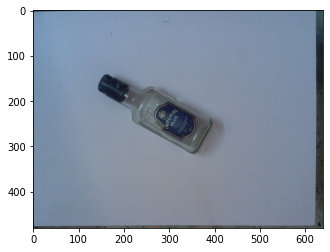

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os, sys
import cv2
img = Image.open('image1.jpg')
print(img.size)
newsize=(640,480)
image1res= img.resize(newsize)
print(image1res.size)
#imgnew=cv2.imread('image1.jpg')
plt.imshow(image1res)
plt.show()
#plt.figure(figsize=newsize)
#plt.imshow(image1res)


In [ ]:
%cd /content/drive/My Drive/object_detection/models/research/object_detection

/content/drive/My Drive/object_detection/models/research/object_detection


/content/drive/My Drive/object_detection/trash1.jpg
plastic


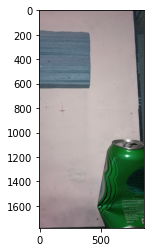

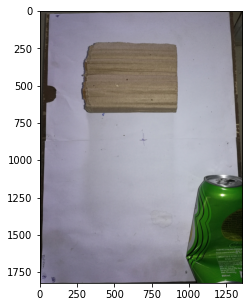

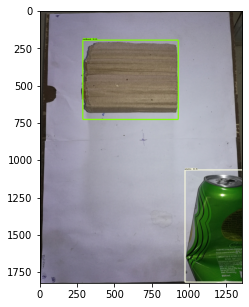

{1: {'id': 1, 'name': 'cardboard'}, 2: {'id': 2, 'name': 'glass'}, 3: {'id': 3, 'name': 'metal'}, 4: {'id': 4, 'name': 'paper'}, 5: {'id': 5, 'name': 'plastic'}}
This box is gonna get used [0.10730694 0.21038753 0.39838803 0.68145424] 1
Current Motor angles are: 62.28691048546224 and 72.85774742643551
This box is gonna get used [0.5845001 0.7142284 0.996552  1.       ] 5
Current Motor angles are: 100.57831737986814 and 51.755760955634656


In [ ]:
#%cd ~/object_detection
%matplotlib inline
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from google.colab import files
import cv2
import math
import csv

# This is needed since the notebook is stored in the object_detection folder.
#%cd /content/drive/My Drive/object_detection/models/research/object_detection
sys.path.append("..")

from object_detection.utils import ops as utils_ops

#if tf.__version__ < '1.4.0':
 # raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  
 
# This is needed to display the images.
%matplotlib inline
from utils import label_map_util

from utils import visualization_utils as vis_util

# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/drive/My Drive/object_detection/models/research/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/drive/My Drive/object_detection/data', 'label_map.pbtxt')

NUM_CLASSES = 5


detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.compat.v1.GraphDef()
  with tf.compat.v1.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/drive/My Drive/object_detection'
PATH_TO_TEST_IMAGES_DIR1 = '/content/drive/My Drive/object_detection/models/research/object_detection'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'trash{}.jpg'.format(1)) ]#for i in range(1, 2)
TEST_IMAGE_PATHS1 = os.path.join(PATH_TO_TEST_IMAGES_DIR, 'trash{}.jpg'.format(1))
print(TEST_IMAGE_PATHS1)
#img = Image.open(TEST_IMAGE_PATHS1)
#print(img.size)
img = cv2.imread(TEST_IMAGE_PATHS1)
#print (img.shape) #3456, 4608
crop_img = img[40:1990, 500:3250]
plt.imshow(crop_img)
cv2.imwrite('trash_cropped1.jpg',crop_img)
#plt.imshow("trash_cropped.jpg")
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR1, 'trash_cropped{}.jpg'.format(1))]

# Size, in inches, of the output images.
IMAGE_SIZE = (5, 5)
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.compat.v1.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.compat.v1.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.compat.v1.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.compat.v1.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  #print(output_dict['detection_boxes'])
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  #print('box coordinates are:'+str(output_dict['detection_boxes'][0]))
  #print('detection score is:'+str(output_dict['detection_scores'][0]))
  #print('category index of detected class is:'+str(output_dict['detection_classes'][0]))
  #print(category_index)
  #files.download(image_np)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.show()
  # This is the way I'm getting my coordinates
  boxes = output_dict['detection_boxes']
  # get all boxes from an array
  max_boxes_to_draw = boxes.shape[0]
  # get scores to get a threshold
  scores = output_dict['detection_scores']
  # this is set as a default but feel free to adjust it to your needs
  min_score_thresh=.5
  print(category_index)
  #make ready the file to write calculated angles
  fields =['ThitaX', 'ThitaY', 'Obj_class']
  filename = "/content/drive/My Drive/object_detection/data/angle_for_detected_objects.txt"
  with open(filename, 'w')as txtfile:
  #with open(filename, 'w')as csvfile:
   #csvwriter = csv.writer(csvfile)
   #csvwriter.writerow(fields)
   txtfile.write("ThitaX, ThitaY, Obj_class \n")
  # iterate over all objects found
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
   #
     if scores is None or scores[i] > min_score_thresh:
       # boxes[i] is the box which will be drawn
       class_name = category_index[output_dict['detection_classes'][i]]['name']
       print ("This box is gonna get used", boxes[i], output_dict['detection_classes'][i])
       ######## further code is for scaling unit################
       #top gives distance of bbx from bottom of the image so to get the centre of the bbx (y1+y2)/2 where y1 is value of y  from the bottom and y2 is also value of y from the bottom and adjust the origin as 0.5
       Y_coordi=((boxes[i][1] + boxes[i][3])/2)-0.5
       #right gives distance of bbx from left of the image so to get the centre of the bbx (x1+x2)/2 where x1 is value of x  from the left and x2 is also value of x from the left and adjust the origin as 0.5
       X_coordi=((boxes[i][0] + boxes[i][2])/2)-0.5
       #scale by 42 at x and 30 at y as origin is shifted to centre of the screen divide the values by 0.5
       actual_x= X_coordi*(42/0.5)
       actual_y= Y_coordi*(30/0.5)
       ######## further code is for inverse kinematics################
       #length of boom is 55 cm#
       thita1rad = math.atan(actual_y/65)
       thita0rad = math.atan(actual_x/65)
       thitay = thita1rad*57.295 #radian to degree conversion
       thitax = thita0rad*57.295 #radian to degree conversion
       #adding offset to the motor angles
       thitax = thitax + 80
       thitay = -thitay + 70
       print("Current Motor angles are: "+str(thitax)+ " and " +str(thitay))
       ####### Further code is for saving the angles into the csv file#########
       with open(filename, 'a+', newline='')as txtfile:
       #with open(filename, 'a+', newline='')as csvfile:
         #csvwriter = csv.writer(csvfile)
         #csvwriter.writerow(["x"+str("{0:0=3d}".format(round(thita0))), "y"+str("{0:0=3d}".format(round(thita1))), "c"+str(output_dict['detection_classes'][i])])
         txtfile.write("x"+str("{0:0=3d}".format(round(thitax)))+"y"+str("{0:0=3d}".format(round(thitay)))+"c"+str(output_dict['detection_classes'][i]))
         txtfile.write("\n")

  files.download('/content/drive/My Drive/object_detection/data/angle_for_detected_objects.txt')
